In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

import os
os.chdir('E:/学习资料/python数据分析/项目资料/项目11国产烂片深度揭秘/')


from bokeh.models import HoverTool
from bokeh.core.properties import value

Loading BokehJS ...

初步清洗后数据量为2306条


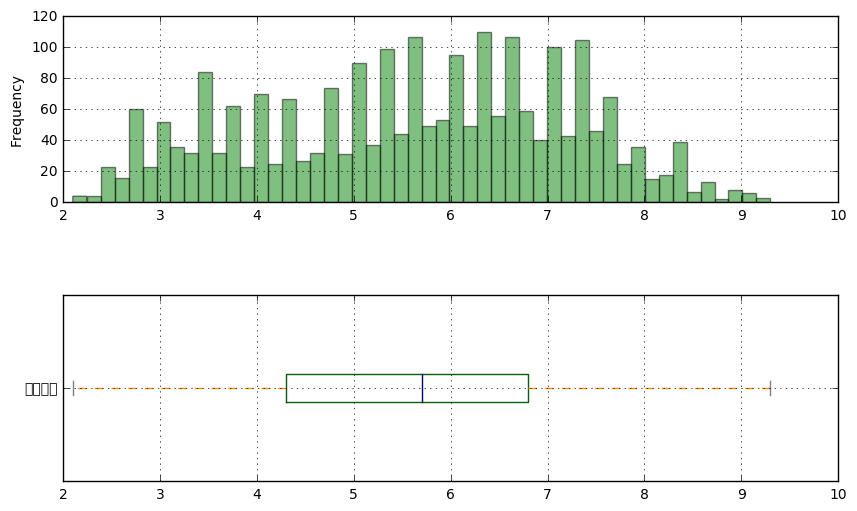

In [3]:
'''
(1) 查看数据，数据清洗

'''

df = pd.read_excel('moviedata.xlsx')
df = df[df['豆瓣评分']>0]
print('初步清洗后数据量为%i条' % len(df))
# 读取数据
# 删除“豆瓣评分”小于等于0的值

'''
(2) 查看豆瓣评分情况

'''

fig = plt.figure(figsize = (10,6))
plt.subplots_adjust(hspace = 0.5)
#设置绘图空间

ax1 = fig.add_subplot(2,1,1)
df['豆瓣评分'].plot.hist(stacked = True,bins = 50,grid = True,
                        color = 'green',alpha = 0.5)
#绘制直方图

ax2 = fig.add_subplot(2,1,2)
color = dict(boxes = 'DarkGreen',whiskers = 'DarkOrange',medians = 'DarkBlue',caps = 'Gray')
df['豆瓣评分'].plot.box(vert = False,grid = True,
                        color = color)

In [9]:
'''
(3) 判断什么是烂片

'''

from scipy import stats

u = df['豆瓣评分'].mean()
std = df['豆瓣评分'].std()

stats.kstest(df['豆瓣评分'],'norm',(u,std))
# 判断是否符合正态分布,这里p值大于0.05，为正态分布
# 结论
# 这里以样本数据上四分位数为烂片评判标准 → 4.3分


# 筛选出烂片数据，并做排名，找到TOP20
q1 = df['豆瓣评分'].quantile(q = 0.25)
data_lp = df[df['豆瓣评分']< q1]
print('数据整理后，得到烂片数据量为%i条' % len(data_lp))
print(q1)
# 筛选烂片数据

lp_top20 = data_lp.sort_values('豆瓣评分',ascending = True).head(20)

数据整理后，得到烂片数据量为546条
4.3


In [10]:
'''
(4) 筛选出所有题材类型，查看不同题材烂片比例

'''

#找出电影类型的名单，并去重
typelst = []

for i in df[df['类型'].notnull()]['类型'].str.replace(' ','').str.split('/'):
    typelst.extend(i)

typelst = list(set(typelst))

#定义函数，计算烂片比例
df_type = df[df['类型'].notnull()][['电影名称','类型','豆瓣评分']]

def f1(data,typei):
    dic_type_lp = {}
    datai = data[data['类型'].str.contains(typei)]
    lp_pre_i = len(datai[datai['豆瓣评分']<4.3])/len(datai)
    
    dic_type_lp['typename'] = typei
    dic_type_lp['typecount'] = len(datai)
    dic_type_lp['type_lp_pre'] = lp_pre_i
    
    return(dic_type_lp)


lst_type_lp = []

for i in typelst:
    dici = f1(df_type,i)
    lst_type_lp.append(dici)
    

df_type_lp = pd.DataFrame(lst_type_lp)    
type_lp_top20 = df_type_lp.sort_values('type_lp_pre',ascending = False).iloc[:20]
type_lp_top20

,type_lp_pre,typecount,typename
10,0.666667,12,情色
3,0.579710,69,恐怖
0,0.561856,194,惊悚
9,0.407407,216,悬疑
16,0.400000,10,灾难
15,0.376471,85,冒险
8,0.370370,27,科幻
26,0.345238,84,奇幻
25,0.341463,574,喜剧
29,0.333333,3,黑色电影


In [11]:
'''
(5) 筛选出所有题材类型，查看不同题材烂片比例

'''

type_lp_top20['size'] = type_lp_top20['typecount']**0.5*2  # 设置点大小，这里通过开方减小数据差距
source = ColumnDataSource(data=type_lp_top20)
# 创建数据

lst_type = type_lp_top20['typename'].tolist()   # 设置横坐标list
hover = HoverTool(tooltips=[("数据量", "@typecount"),
                           ("烂片比例","@type_lp_pre")]) # 设置标签显示内容

p = figure(x_range=lst_type, plot_width=900, plot_height=350, title="不同电影题材烂片比例", 
           tools=[hover,'reset,xwheel_zoom,pan,crosshair,box_select'])
# 构建绘图空间

p.circle(x='typename',y='type_lp_pre',source = source, size = 'size',
         line_color = 'black',line_dash = [6,4],fill_color = 'red',fill_alpha = 0.7)
# 绘制散点图

p.xgrid.grid_line_dash = [10,4]
p.ygrid.grid_line_dash = [10,4]
# 设置其他参数

show(p)


In [12]:
'''
(1)按照“制片国家/地区”字段分类，筛选不同电影的制片地

'''

df_loc = df[['电影名称','豆瓣评分','制片国家/地区']][df['制片国家/地区'].notnull()]
df_loc = df_loc[df_loc['制片国家/地区'].str.contains('中国大陆')]
#要的是中外合拍，制片地必须有中国大陆

'''
(2)整理数据，按照“地区”汇总，查看不同题材的烂片比例

'''

#提炼出地区名单

loc_lst = []
for i in df_loc['制片国家/地区'].str.replace(' ','').str.split('/'):
    loc_lst.extend(i)
#处理出来的数据有几种情况，一种是中国大陆与其他地区合拍，一种是只有中国大陆，
#因此需要将中国大陆删去，只留下合拍地，同时删去属于中国的港澳台地区
    
loc_lst = list(set(loc_lst))
loc_lst.remove('中国大陆')     
loc_lst.remove('中国')
loc_lst.remove('台湾')
loc_lst.remove('香港')

#定义函数

def f2(data,loci):
    dic_loc_lp = {}
    datai = data[data['制片国家/地区'].str.contains(loci)]
    lp_prei = len(datai[datai['豆瓣评分']<4.3])/len(datai)
    dic_loc_lp['loc'] = loci
    dic_loc_lp['loc_lp_pre'] = lp_prei
    dic_loc_lp['loccount'] = len(datai)
    return(dic_loc_lp)

lst_loc_lp = []
for i in loc_lst:
    dici = f2(df_loc,i)
    lst_loc_lp.append(dici)

df_loc_lp = pd.DataFrame(lst_loc_lp)
df_loc_lp = df_loc_lp[df_loc_lp['loccount']>=3]
df_loc_lp.sort_values('loc_lp_pre',ascending = False)

,loc,loc_lp_pre,loccount
7,英国,0.750000,4
13,美国,0.333333,21
15,新加坡,0.333333,3
0,德国,0.250000,4
14,韩国,0.157895,19
1,法国,0.100000,10
22,日本,0.071429,14
3,澳大利亚,0.000000,3
11,加拿大,0.000000,6


In [102]:
'''
(4)卡司数量是否和烂片有关

'''

#计算每部电影的主演人数,按照主演人数分类，并统计烂片率
df_actor = df[['电影名称','主演','豆瓣评分']][df['主演'].notnull()]
df_actor['主演人数'] = df_actor['主演'].str.split('/').str.len()
df_actor['主演人数分类'] = pd.cut(df_actor['主演人数'],[0,2,4,6,9,50],labels = ['1-2人','3-4人','5-6人','7-9人','10人及以上'])


# 查看烂片比例最高的演员TOP20
df_actor_lp = df_actor[df_actor['豆瓣评分']<4.3].groupby('主演人数分类').count()
df_actor_zs = df_actor.groupby('主演人数分类').count()

result = pd.merge(df_actor_zs,df_actor_lp,left_index = True,right_index = True)[['电影名称_x','电影名称_y']]
result.columns = ['电影数量','烂片数量']
result['烂片比例'] =  result['烂片数量'] / result['电影数量']

result

,电影数量,烂片数量,烂片比例
主演人数分类,,,
1-2人,273,30,0.109890
3-4人,651,117,0.179724
5-6人,466,130,0.278970
7-9人,426,157,0.368545
10人及以上,393,104,0.264631


In [4]:
'''
(5)筛选不同主演的烂片比例

'''

#将名单筛选出来,只要烂片数据的名单
df_role1 = df[(df['主演'].notnull())&(df['豆瓣评分']<4.3)]
df_role2 = df[df['主演'].notnull()]


role_lst = []
for i in df_role1['主演'].str.replace(' ','').str.split('/'):
    role_lst.extend(i)
    
role_lst = list(set(role_lst))
print(len(role_lst))

#定义函数(这里去除掉拍过3次电影以下的演员)

def f3(data,rolei):
    dic_role_lp = {}
    datai = df_role2[df_role2['主演'].str.contains(rolei)]
    if len(datai) > 2:
        prei = len(datai[datai['豆瓣评分']<4.3])/len(datai)
        dic_role_lp['role'] = rolei
        dic_role_lp['rolecount'] = len(datai)
        dic_role_lp['role_lp_pre'] = prei
    return(dic_role_lp)


lst_role_lp = []

for i in role_lst:
    dici = f3(df_role2,i)
    lst_role_lp.append(dici)
    
df_role_lp = pd.DataFrame(lst_role_lp)
df_role_lp.dropna(inplace = True)
print(df_role_lp.sort_values('role_lp_pre',ascending = False).iloc[:20])

# 查看特定演员的烂片率
print(df_role_lp[df_role_lp['role'] == '吴亦凡'])
df_role2[['电影名称','主演','豆瓣评分']][df_role2['主演'].str.contains('吴亦凡')] 

2667
role           熊欣欣宋慧乔鲍起静林妙可云翔大庆姜潮吴静田启文吕晶吴中天蒋璐霞倪大红高亚麟热依扎马羚温超李承...
role_lp_pre                                              318.785
rolecount                                                   5486
dtype: object
    role  role_lp_pre  rolecount
215  吴亦凡     0.666667        3.0


,电影名称,主演,豆瓣评分
38,爵迹,范冰冰 / 吴亦凡 / 陈学冬 / 陈伟霆 / 郭采洁 / 杨幂 / 林允 / 严屹宽 /...,3.7
57,致青春·原来你还在这里,吴亦凡 / 刘亦菲 / 金世佳 / 李沁 / 李梦 / 郝劭文 / 陈燃 / 乔任梁,4.0
350,有一个地方只有我们知道,吴亦凡 / 王丽坤 / 徐静蕾 / 戈登·亚历山大 / 丛珊 / 张超 / 热依扎,5.0


In [7]:
'''
(6)不同导演每年电影产量情况是如何的

'''

#通过“上映日期”筛选出每个电影的上映年份
df_year = df[['电影名称','导演','豆瓣评分','上映日期']][df['导演'].notnull()]
df_year = df_year[df_year['上映日期'].notnull()]
df_year['上映日期'] = df_year['上映日期'].str.replace(' ','')  # 删除空格字符
df_year['year'] = df_year['上映日期'].str[:4]   # 识别年份
df_year = df_year[df_year['year'].str[0] == '2']  # 去除错误数据
df_year['year'] = df_year['year'].astype(np.int)   # 年份设置为整型
df_year.head()

,电影名称,导演,豆瓣评分,上映日期,year
7,我心雀跃,刘紫微,6.7,2017-04(中国大陆)/2016-06-14(上海国际电影节),2017
19,龙门劫案,王勇,4.0,2016年,2016
20,东北小佛爷,谢云鹏,6.5,2016-6-16,2016
21,一个成人电影工作者的自白,贾小熊,7.6,2016-6-15,2016
23,宠灵实验室之狸奴艾莉,郝昭赫,3.7,2016-4-1,2016


In [8]:
#查看不同导演的烂片比例、这里去除掉拍过10次电影以下的导演

#定义名单
dir_lst = []
for i in df_year['导演'].str.replace(' ','').str.split('/'):
    dir_lst.extend(i)

dir_lst = list(set(dir_lst))
print(len(dir_lst))
#设置循环

lst_dir_lp = []

for i in dir_lst:
    datai = df_year[df_year['导演'].str.contains(i)]
    if len(datai)>10:
        dic_dir_lp = {}
        dic_dir_lp['dir'] = i
        dic_dir_lp['dircount'] = len(datai)
        dic_dir_lp['dir_lp_pre'] = len(datai[datai['豆瓣评分']<4.3])/len(datai)
        lst_dir_lp.append(dic_dir_lp)
        

df_dir_lp = pd.DataFrame(lst_dir_lp)
df_dir_lp

1485


,dir,dir_lp_pre,dircount
0,王晶,0.210526,19
1,邓衍成,0.030303,33
2,胡明凯,0.000000,16
3,周伟,0.071429,14
4,海涛,0.000000,12
5,徐克,0.090909,11


In [9]:
#查看不同导演每年的电影产量制作散点图 → 横坐标为年份，纵坐标为每年电影平均分，点大小该年电影数量

df_year = df_year[(df_year['year']>=2007)&(df_year['year']<=2017)]

def f4(data,diri):
    datai = data[data['导演'].str.contains(diri)]
    data_scoremean = datai.groupby('year').mean()
    data_count = datai.groupby('year').count()['豆瓣评分']
    result = pd.merge(data_scoremean,pd.DataFrame(data_count),left_index = True,right_index = True)
    result.columns = ['score','count']
    result['size'] = result['count']*5
    result = result.reset_index()
    return(result)
    
dirdata1 = f4(df_year,'王晶')    
dirdata2 = f4(df_year,'周伟')
dirdata3 = f4(df_year,'徐克')
dirdata4 = f4(df_year,'邓衍成')

from bokeh.models.annotations import BoxAnnotation   

hover = HoverTool(tooltips = [('该年电影平均分','@score'),('该年电影数量','@count')])
p = figure(plot_width = 900,plot_height = 350,
           title = '不同导演每年的电影产量及均分',
           tools = [hover,'reset,crosshair'])

source1 = ColumnDataSource(dirdata1)
p.circle(x = 'year',y='score',size = 'size',legend = '王晶',source = source1,color = 'olive')

source2 = ColumnDataSource(dirdata2)
p.circle(x = 'year',y='score',size = 'size',legend = '周伟',source = source2,color = 'blue')

source3 = ColumnDataSource(dirdata3)
p.circle(x = 'year',y='score',size = 'size',legend = '徐克',source = source3,color = 'green')

source4 = ColumnDataSource(dirdata4)
p.circle(x = 'year',y='score',size = 'size',legend = '邓衍成',source = source4,color = 'gray')

p.xgrid.grid_line_dash = [10,4]
p.ygrid.grid_line_dash = [10,4]
p.legend.location = "top_right"
# 设置其他参数

bg = BoxAnnotation(top = 4.4,fill_alpha = 0.1,fill_color = 'red')
p.add_layout(bg)

show(p)

dirdata1.sum()

year     20115.0
score       53.2
count       19.0
size        95.0
dtype: float64